<a href="https://colab.research.google.com/github/EdgarSuritis/410Final/blob/main/ML_Final_Milestone_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Environment

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 31.4 MB/s eta 0:00:00


In [ ]:
!pip install torch torchvision torchaudio timm opencv-python albumentations numpy matplotlib seaborn wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.2/340.2 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.8/307.8 kB 20.3 MB/s eta 0:00:00


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 15.2 MB/s eta 0:00:00


In [ ]:
!pip install torch --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116


In [ ]:
!pip install torchmetrics

# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import PIL
import torchvision

In [ ]:
from timm.models.swin_transformer import SwinTransformer #https://arxiv.org/pdf/2103.14030

In [ ]:
import cv2
import numpy as np

In [ ]:
from torchmetrics import detection #We're using detection.mean_ap

In [ ]:
import sys
import xml.etree.ElementTree as ET

# Data Import & Dataloader

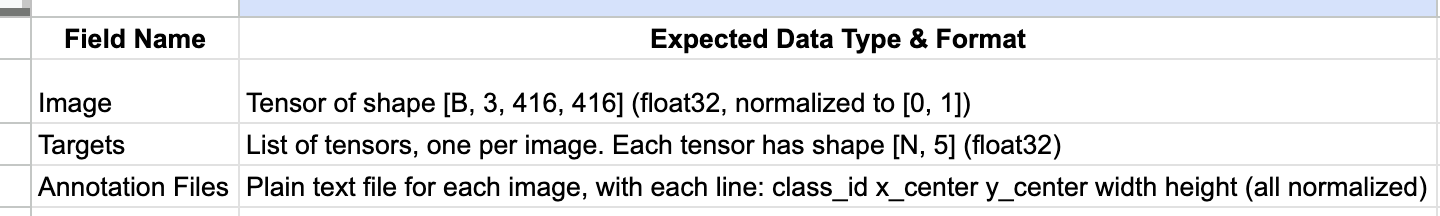

**Image:** An RGB image. All images are resized to 416×416 pixels.

**Targets:** Each row represents one positively annotated bounding box. The row format is: [class_id, x_center, y_center, width, height]. All coordinates are normalized (i.e. values between 0 and 1). The class_id is an integer corresponding to one of the dangerous goods (e.g., 0: gun, 1: knife, 2: wrench, 3: pliers, 4: scissors, 5: hammer).

**Annotations:**These files accompany each image in a labels directory. The preprocessing stage reads these files and transforms the data into the tensor format described above.

In [ ]:
# Datasets.py code (should be in its own separate file):

import torch
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

def custom_collate_fn(batch):
    """
    Collates the batch such that images are stacked and targets
    are returned as a list.

    Args:
        batch: list of tuples (image, targets)
    Returns:
        images: a stacked tensor of shape [B, 3, 416, 416]
        targets: a list of tensors (each can have different shape, e.g. [N, 4])
    """
    images = torch.stack([item[0] for item in batch], 0)
    targets = [item[1] for item in batch]
    return images, targets


# =============================================================================
# Dataset Class: Reads CSV file for file names and uses XML annotation files.
# =============================================================================
class SixrayDataset(Dataset):
    """
    Reads SIXray images and their annotations.

    It uses a CSV file that contains at least a column named "name" (e.g. "P00007")
    and (optionally) other columns (like "Gun", "Knife", etc.) which we ignore.

    For positive images (those whose name starts with "P"), it loads the corresponding
    XML file from the annotations directory; if the XML file is missing or the image is
    negative, it returns an empty array for bounding boxes.

    Each sample is a dictionary with:
      - "image": a NumPy array (RGB)
      - "bounding_boxes": a NumPy array of shape [N, 5] with rows:
              [class, x_center, y_center, w, h] (all normalized to [0,1])

    Args:
      csv_fname (str): Path to the CSV file (e.g., train.csv or test.csv).
      images_dir (str): Directory containing the JPEG images.
      annotations_dir (str): Directory containing the positive XML files.
      transform (callable, optional): A transform to be applied on the sample.
    """
    def __init__(self, csv_fname, images_dir, annotations_dir, transform=None):
        self.fnames = pd.read_csv(csv_fname, delimiter=',', header=0)
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        # This mapping converts XML class names to numeric classes.
        self.class_id = {"Gun": 0, "Knife": 1, "Wrench": 2, "Pliers": 3, "Scissors": 4, "Hammer": 5}

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        # Get the image file name from CSV (assume the CSV has a column "name")
        row = self.fnames.iloc[idx]
        file_name = row['name']  # e.g., "P00007"

        image_path = os.path.join(self.images_dir, file_name + ".jpg")
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)

        # Initialize an empty list for bounding boxes.
        bounding_boxes = []
        # Determine if image is positive by its name (if it starts with 'P', we assume positive)
        if file_name[0] == 'P':
            xml_path = os.path.join(self.annotations_dir, file_name + ".xml")
            if os.path.exists(xml_path):
                try:
                    tree = ET.parse(xml_path)
                    root = tree.getroot()
                    # Get original image size from XML we use these for normalization.
                    size_node = root.find('size')
                    orig_width = float(size_node.find('width').text)
                    orig_height = float(size_node.find('height').text)

                    for obj in root.findall('object'):
                        name_node = obj.find('name')
                        if name_node is None:
                            continue
                        class_name = name_node.text
                        if class_name not in self.class_id:
                            continue
                        c = self.class_id[class_name]
                        bndbox = obj.find('bndbox')
                        xmin = float(bndbox.find('xmin').text)
                        ymin = float(bndbox.find('ymin').text)
                        xmax = float(bndbox.find('xmax').text)
                        ymax = float(bndbox.find('ymax').text)
                        # Convert to YOLO format (normalized center x, center y, width, height)
                        x_center = ((xmin + xmax) / 2.0) / orig_width
                        y_center = ((ymin + ymax) / 2.0) / orig_height
                        box_w = (xmax - xmin) / orig_width
                        box_h = (ymax - ymin) / orig_height
                        bounding_boxes.append([c, x_center, y_center, box_w, box_h])
                except Exception as e:
                    print(f"Error parsing XML for {file_name}: {e}")
        # For negative images, no bounding boxes needed.
        bounding_boxes = np.array(bounding_boxes, dtype=np.float32)

        sample = {"image": image_np, "bounding_boxes": bounding_boxes}
        if self.transform:
            sample = self.transform(sample)
        return sample

# =============================================================================
# Transformation: We use Albumentations package to apply consistent augmentations to both image and boxes.
# =============================================================================
def custom_transform(sample, alb_transform):
    """
    Converts the sample dict into the format expected by Albumentations.

    - The sample contains "image" (as a NumPy array) and "bounding_boxes" (a NumPy array [N, 5]).
    - We convert the bounding_boxes into two lists:
         bboxes: list of [x_center, y_center, w, h]
         labels: list of class IDs.
    Then apply the alb_transform.
    """
    image = sample["image"]
    boxes = sample["bounding_boxes"]
    if boxes.size == 0:
        bboxes = []
        labels = []
    else:
        bboxes = boxes[:, 1:].tolist()  # Extract box coordinates.
        labels = boxes[:, 0].tolist()     # Extract class labels.
    transformed = alb_transform(image=image, bboxes=bboxes, labels=labels)
    # Ensure the transformed image is a float tensor due to prior error.
    transformed["image"] = transformed["image"].float()
    return {"image": transformed["image"], "bounding_boxes": transformed["bboxes"], "labels": transformed["labels"]}

# =============================================================================
# A Wrapper Dataset that applies our custom_transform to the raw SixrayDataset output.
# =============================================================================
class SixrayWrapper(Dataset):
    def __init__(self, csv_fname, images_dir, annotations_dir, alb_transform):
        self.dataset = SixrayDataset(csv_fname, images_dir, annotations_dir, transform=None)
        self.alb_transform = alb_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]  # returns {"image": ..., "bounding_boxes": ..., "labels": ...}
        sample = custom_transform(sample, self.alb_transform)
        # Now sample["bounding_boxes"] is a list of bboxes [x_center, y_center, w, h]
        # and sample["labels"] is a list of class ids.
        if len(sample["bounding_boxes"]) > 0:
            # Convert both lists to tensors and concatenate along dimension 1.
            labels = torch.tensor(sample["labels"]).unsqueeze(1).float()  # shape: [N, 1]
            bboxes = torch.tensor(sample["bounding_boxes"]).float()       # shape: [N, 4]
            targets = torch.cat([labels, bboxes], dim=1)  # shape: [N, 5]
        else:
            targets = torch.empty((0, 5))
        return sample["image"], targets


# =============================================================================
# Albumentations Transformation Pipelines for Training and Testing. (From Paper)
# =============================================================================
def get_albumentations_transform(train=True):
    if train:
        return A.Compose([
            A.Resize(416, 416),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='yolo', label_fields=['labels']))
    else:
        return A.Compose([
            A.Resize(416, 416),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='yolo', label_fields=['labels']))


# =============================================================================
# DataLoader Creator Function
# =============================================================================
def get_dataloader(csv_fname, images_dir, annotations_dir, batch_size=32, train=True):
    alb_transform = get_albumentations_transform(train=train)
    dataset = SixrayWrapper(csv_fname, images_dir, annotations_dir, alb_transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=train, num_workers=4)


In [ ]:
import os
import torch
#from datasets import get_dataloader, custom_collate_fn

# =============================================================================
# Adjust these paths according to your folder structure.
# =============================================================================
if __name__ == '__main__':
    # For the train_test_easy split
    base_dir = "~/Desktop/Applied ML/ML-Project/test-data"

    # Use the CSV files in the easy split folder:
    csv_train = os.path.join(base_dir, "TestTrainSplits", "train_test_easy", "train.csv")
    csv_test  = os.path.join(base_dir, "TestTrainSplits", "train_test_easy", "test.csv")

    # Directory containing JPEG images.
    images_dir = os.path.join(base_dir, "JPEGImageFull", "dataset", "JPEGImage")
    # Directory containing positive XML annotations.
    annotations_dir = os.path.join(base_dir, "positive-Annotation")

    # DataLoaders for training and testing.
    # Pass the custom collate function here:
    train_loader = get_dataloader(csv_train, images_dir, annotations_dir, batch_size=32, train=True)
    test_loader  = get_dataloader(csv_test, images_dir, annotations_dir, batch_size=32, train=False)

    # When creating the DataLoader inside get_dataloader, set the collate_fn parameter
    # For example, modify get_dataloader to:
    # return DataLoader(dataset, batch_size=batch_size, shuffle=train, num_workers=4, collate_fn=custom_collate_fn)

    # For our testing, we can either modify get_dataloader() or wrap it here:
    from torch.utils.data import DataLoader
    # Reconstruct using our custom_collate_fn for demonstration:
    train_loader = DataLoader(train_loader.dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=custom_collate_fn)

    # Simple test: iterate through one batch.
    for imgs, targets in train_loader:
        print("Train Images shape:", imgs.shape)  # Expected: [batch, 3, 416, 416]
        print("Train Targets:", targets)  # A list, each element a tensor of shape [N, 4] (or [N, 5] if you include classes)
        break

# Model

In this part, we are creating a YOLO-T model. The model uses a Swin Transformer as the backbone (loaded from the timm library) and a custom YOLO detection head that fuses features from three scales. The detection head mimics the YOLOv3 design for multi-scale predictions.

---

Ways we can try and improve from this model:
- Use the latest YOLO model.
- Add the EAOD-Net modifications.
- Try and use the information gained from the extraction with another model: like neural-net, random forest, and other applicable ones.
- Balance between precision and accuracy. [Training a model that has high accuracy, a model that has high precision, and then putting the results from both of those together.]

In [ ]:
# @title
import torch.nn as nn
import torch.optim as optim
import timm
import math

# Define anchors for each scale (example values; normalize relative to input size 416)
ANCHORS = {
    'large':  [(0.10, 0.13), (0.16, 0.30), (0.33, 0.23)],  # for 52x52
    'medium': [(0.22, 0.27), (0.38, 0.56), (0.95, 0.80)],  # for 26x26
    'small':  [(0.90, 1.10), (1.87, 3.23), (4.42, 2.74)]   # for 13x13
}
# Note: These anchor values are exemplary. In a production setup, use k-means on SIXray boxes.

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

class YOLOLoss(nn.Module):
    def __init__(self, anchors, num_classes, img_dim=416, ignore_thresh=0.5,
                 lambda_coord=5.0, lambda_noobj=0.5):
        """
        anchors: list of (w, h) for this scale (normalized)
        num_classes: number of classes
        img_dim: input image dimension (assumed square)
        ignore_thresh: IoU threshold for ignoring objectness loss in no-object cells
        lambda_coord: weight for coordinate loss
        lambda_noobj: weight for no-object confidence loss
        """
        super(YOLOLoss, self).__init__()
        self.anchors = anchors  # for one scale
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.img_dim = img_dim
        self.ignore_thresh = ignore_thresh
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.mse_loss = nn.MSELoss(reduction='sum')
        self.bce_loss = nn.BCELoss(reduction='sum')
        self.ce_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, prediction, targets):
        """
        prediction: tensor of shape [batch, (5+num_classes)*num_anchors, grid, grid]
        targets: list of targets for each image; each target is a tensor of shape [N, 5],
                 with [cls, x_center, y_center, w, h] in normalized coordinates.
        """
        batch_size = prediction.size(0)
        grid_size = prediction.size(2)  # square grid
        stride = self.img_dim / grid_size

        prediction = prediction.view(batch_size, self.num_anchors, self.num_classes + 5, grid_size, grid_size)
        prediction = prediction.permute(0, 1, 3, 4, 2).contiguous()  # shape: [B, A, grid, grid, 5+num_classes]

        # Get outputs
        pred_tx = prediction[..., 0]  # center x
        pred_ty = prediction[..., 1]  # center y
        pred_tw = prediction[..., 2]  # width
        pred_th = prediction[..., 3]  # height
        pred_conf = prediction[..., 4]  # objectness
        pred_cls = prediction[..., 5:]  # class scores

        # Create grid offsets
        grid_x = torch.arange(grid_size).repeat(grid_size, 1).view([1, 1, grid_size, grid_size]).type_as(prediction)
        grid_y = torch.arange(grid_size).repeat(grid_size, 1).t().view([1, 1, grid_size, grid_size]).type_as(prediction)

        # Transform predictions to bounding box coordinates
        # According to YOLOv3:
        # x = sigmoid(tx) + grid_x, similarly for y.
        # w = anchor_w * exp(tw), h = anchor_h * exp(th)
        pred_boxes = torch.zeros(prediction[..., :4].shape).type_as(prediction)
        pred_boxes[..., 0] = (sigmoid(pred_tx) + grid_x) / grid_size
        pred_boxes[..., 1] = (sigmoid(pred_ty) + grid_y) / grid_size
        # Prepare anchors tensor
        anchors_tensor = torch.tensor(self.anchors).type_as(prediction)  # shape: [num_anchors, 2]
        anchors_tensor = anchors_tensor.view(1, self.num_anchors, 1, 1, 2)
        pred_boxes[..., 2] = anchors_tensor[..., 0] * torch.exp(pred_tw)
        pred_boxes[..., 3] = anchors_tensor[..., 1] * torch.exp(pred_th)

        # Convert targets to tensor for matching.
        # For each image, create a target tensor of shape [batch, num_anchors, grid, grid, 5+num_classes]
        target_tensor = torch.zeros_like(prediction)
        # Also create object mask.
        obj_mask = torch.zeros(batch_size, self.num_anchors, grid_size, grid_size).type_as(prediction)
        noobj_mask = torch.ones(batch_size, self.num_anchors, grid_size, grid_size).type_as(prediction)
        class_mask = torch.zeros(batch_size, self.num_anchors, grid_size, grid_size).type_as(prediction)
        t_box = torch.zeros_like(pred_boxes)

        for b in range(batch_size):
            if targets[b].nelement() == 0:
                continue
            for target in targets[b]:
                # target: [cls, x, y, w, h]
                cls = target[0]
                x, y, w, h = target[1], target[2], target[3], target[4]
                i = int(x * grid_size)
                j = int(y * grid_size)
                # Find best anchor based on IoU between target and anchors (ignoring grid cell offset)
                gt_box = torch.tensor([0, 0, w, h]).unsqueeze(0)  # center not needed here
                anchor_shapes = torch.cat([torch.zeros((self.num_anchors,2)), anchors_tensor[0, :, 0, 0, :]], dim=1)
                # Compute IoU between gt_box and each anchor box
                inter = torch.min(gt_box[:,2:], anchor_shapes[:,2:]).prod(1)
                union = (gt_box[:,2:]*torch.ones_like(anchor_shapes[:,2:])).prod(1) + anchor_shapes[:,2:].prod(1) - inter
                ious = inter / (union + 1e-6)
                best_anchor = torch.argmax(ious)

                # Assign ground truth to this grid cell and anchor
                obj_mask[b, best_anchor, j, i] = 1
                noobj_mask[b, best_anchor, j, i] = 0
                target_tensor[b, best_anchor, j, i, 0] = sigmoid(x * grid_size - i)  # target tx
                target_tensor[b, best_anchor, j, i, 1] = sigmoid(y * grid_size - j)  # target ty
                target_tensor[b, best_anchor, j, i, 2] = math.log(w / (self.anchors[best_anchor][0] + 1e-6) + 1e-6)
                target_tensor[b, best_anchor, j, i, 3] = math.log(h / (self.anchors[best_anchor][1] + 1e-6) + 1e-6)
                target_tensor[b, best_anchor, j, i, 4] = 1  # object exists
                # Class one-hot encoding
                target_tensor[b, best_anchor, j, i, 5 + int(cls)] = 1

        # Losses:
        # Localization loss (for x, y, w, h)
        loss_x = self.mse_loss(sigmoid(pred_tx) * obj_mask, target_tensor[...,0] * obj_mask)
        loss_y = self.mse_loss(sigmoid(pred_ty) * obj_mask, target_tensor[...,1] * obj_mask)
        loss_w = self.mse_loss(torch.sqrt(torch.abs(pred_boxes[...,2] + 1e-6)) * obj_mask,
                               torch.sqrt(torch.abs(torch.exp(target_tensor[...,2])) * obj_mask))
        loss_h = self.mse_loss(torch.sqrt(torch.abs(pred_boxes[...,3] + 1e-6)) * obj_mask,
                               torch.sqrt(torch.abs(torch.exp(target_tensor[...,3])) * obj_mask))
        loss_coord = self.lambda_coord * (loss_x + loss_y + loss_w + loss_h)

        # Confidence loss:
        loss_conf_obj = self.bce_loss(sigmoid(pred_conf) * obj_mask, target_tensor[...,4] * obj_mask)
        loss_conf_noobj = self.lambda_noobj * self.bce_loss(sigmoid(pred_conf) * noobj_mask,
                                                            target_tensor[...,4] * noobj_mask)
        loss_conf = loss_conf_obj + loss_conf_noobj

        # Classification loss:
        # For each cell with an object, use cross entropy loss. Reshape predictions.
        pred_cls = pred_cls[obj_mask.bool()]
        target_cls = target_tensor[..., 5:][obj_mask.bool()]
        # target_cls is one-hot; get the index.
        if pred_cls.nelement() > 0:
            target_cls_index = torch.argmax(target_cls, dim=-1)
            loss_cls = self.ce_loss(pred_cls, target_cls_index)
        else:
            loss_cls = torch.tensor(0.0).type_as(prediction)

        total_loss = loss_coord + loss_conf + loss_cls
        return total_loss

# Define the YOLO Head (as before) and YOLO-T Model.
class YOLOHead(nn.Module):
    def __init__(self, num_classes=6, in_channels=[192, 384, 768]):
        super(YOLOHead, self).__init__()
        # Small-scale branch: from the smallest (in_channels[2] = 768)
        self.conv_small = nn.Sequential(
            nn.Conv2d(in_channels[2], 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, (num_classes + 5) * 3, kernel_size=1)
        )
        # Medium-scale branch: upsample small to fuse with medium.
        self.conv_medium_upsample = nn.Conv2d(in_channels[2], 128, kernel_size=1)
        self.conv_medium = nn.Sequential(
            nn.Conv2d(in_channels[1] + 128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, (num_classes + 5) * 3, kernel_size=1)
        )
        # Large-scale branch: upsample the fused medium feature (which has 512 channels)
        # so conv_large_upsample must accept 512 channels.
        self.conv_large_upsample = nn.Conv2d(512, 64, kernel_size=1)  # Changed from 256 to 512
        self.conv_large = nn.Sequential(
            nn.Conv2d(in_channels[0] + 64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, (num_classes + 5) * 3, kernel_size=1)
        )

    def forward(self, feats):
        # feats is a list: [large (from backbone, 192 channels), medium (384), small (768)]
        large, medium, small = feats[0], feats[1], feats[2]
        # Small-scale prediction:
        pred_small = self.conv_small(small)
        # Upsample small feature and fuse it with medium feature:
        up_small = nn.functional.interpolate(small, scale_factor=2, mode='nearest')
        up_small = self.conv_medium_upsample(up_small)  # outputs 128 channels
        fused_medium = torch.cat([up_small, medium], dim=1)  # shape becomes [B, 128+384=512, .]
        pred_medium = self.conv_medium(fused_medium)
        # For large-scale prediction: upsample the fused medium feature:
        up_medium = nn.functional.interpolate(fused_medium, scale_factor=2, mode='nearest')
        up_medium = self.conv_large_upsample(up_medium)  # now expects [B,512, .] and outputs 64 channels
        fused_large = torch.cat([up_medium, large], dim=1)  # [B,64+192=256, .]
        pred_large = self.conv_large(fused_large)
        return [pred_large, pred_medium, pred_small]


class YOLOTModel(nn.Module):
    def __init__(self, num_classes=6):
        super(YOLOTModel, self).__init__()
        # Set img_size=416 for proper input size.
        self.backbone = timm.create_model('swin_tiny_patch4_window7_224',
                                           pretrained=True,
                                           img_size=416,
                                           features_only=True,
                                           out_indices=(1, 2, 3))
        self.head = YOLOHead(num_classes=num_classes, in_channels=[192, 384, 768])

    def forward(self, x):
        feats = self.backbone(x)
        # Ensure each feature map is in NCHW order.
        for i, feat in enumerate(feats):
            # Check if the second dimension (channels) is smaller than the last dimension;
            # if so, assume the tensor is in NHWC format and permute it.
            if feat.dim() == 4 and feat.shape[1] < feat.shape[-1]:
                feats[i] = feat.permute(0, 3, 1, 2)
        preds = self.head(feats)
        return preds


# Instantiate model and loss functions for each scale.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = YOLOTModel(num_classes=6).to(device)

# Create one YOLOLoss instance per scale using corresponding anchors.
loss_large = YOLOLoss(ANCHORS['large'], num_classes=6, img_dim=416, ignore_thresh=0.5,
                        lambda_coord=5.0, lambda_noobj=0.5)
loss_medium = YOLOLoss(ANCHORS['medium'], num_classes=6, img_dim=416, ignore_thresh=0.5,
                         lambda_coord=5.0, lambda_noobj=0.5)
loss_small = YOLOLoss(ANCHORS['small'], num_classes=6, img_dim=416, ignore_thresh=0.5,
                        lambda_coord=5.0, lambda_noobj=0.5)

# Training loop combining losses from all scales.
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
def train_model(model, dataloader, optimizer, device, num_epochs=50):
    model.train()
    # num_epochs = ... # (can change it here for testing)
    for epoch in range(num_epochs):
        total_loss_epoch = 0.0
        for batch_idx, (images, targets) in enumerate(dataloader):
            images = images.to(device)
            optimizer.zero_grad()
            # Get predictions from model; each element in preds is for one scale.
            preds = model(images)  # list of three tensors
            # Compute loss for each scale
            loss_l = loss_large(preds[0], targets)
            loss_m = loss_medium(preds[1], targets)
            loss_s = loss_small(preds[2], targets)
            loss = loss_l + loss_m + loss_s
            loss.backward()
            optimizer.step()
            total_loss_epoch += loss.item()
            if batch_idx % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} Loss: {loss.item():.4f}")
        avg_loss = total_loss_epoch / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")
        torch.save(model.state_dict(), f'yolot_epoch_{epoch+1}.pth')

print("Starting Training...")
#train_model(model, train_loader, optimizer, device, num_epochs=1)